In [1]:
import datetime as dt
import os
import sys
import sqlalchemy as sa
import pandas as pd
import numpy as np

In [2]:
# Setup connection parameters
comp = os.environ["COMPUTERNAME"]  # Get the computer name from environment variables
dbase = "Financial_Securities"     # Define the name of the database

username = os.getlogin()
external_folder_path = 'C:/Users/' + username + '/Documents/Projects/Financial_Securities/Custom_Python_Functions'
sys.path.append(external_folder_path)
from custom_python_functions import create_connection, get_pricing_data, plot_pricing_candlestick
from custom_python_functions import plot_pricing_line, calculate_return, plot_returns_bar_chart, calculate_stats
from custom_python_functions import plot_period_stats_by_year_bar_charts, plot_period_returns_by_year_box_plot
from custom_python_functions import plot_top_returns_bar_chart, plot_returns_line_chart, calculate_drawdowns

# Create a connection to the database
s, e = create_connection(comp, dbase, "", "")
s1 = s()  # Instantiate a session object

In [3]:
# Define SQL query to retrieve tickers from the Yahoo_Equity_Prices table
sql_stat = """SELECT 
        TRIM(q2.Ticker) AS Ticker,
        q1.Date,
        ROUND(q1.[Open], 2) AS "Open",
        ROUND(q1.[High], 2) AS "High",
        ROUND(q1.[Low], 2) AS "Low",
        ROUND(q1.[Close], 2) AS "Close",
        q1.Volume AS "Volume"
FROM [Financial_Securities].[Equities].[Yahoo_Equity_Prices] q1
INNER JOIN [Financial_Securities].[Equities].[Equities] q2
ON q1.Ticker_ID = q2.Ticker_ID
ORDER BY q2.Ticker, q1.Date
"""

try:
    # Execute the SQL query and read the results into a DataFrame
    df_pricing = pd.read_sql(sql_stat, s1.bind)
    
except sa.exc.SQLAlchemyError as e:
    # Handle exceptions during SQL query execution
    print(f"Issue querying database tables! Error: {e}")
    s1.close()
    raise
    

In [4]:
if df_pricing.empty:
    raise ValueError("DataFrame is empty after SQL query.")
    
df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])
df_pricing['Year'] = df_pricing['Date'].dt.year
df_pricing.sort_values(by=['Ticker', 'Date'], inplace=True)

# Default Ticker used in single ticker analysis
ticker = 'MSFT'

df_pricing_yr = get_pricing_data(df_pricing, 'Year') 
df_pricing_yr_ticker = df_pricing_yr[df_pricing_yr['Ticker'] == ticker].copy()
df_pricing_yr_ticker.sort_values(by=['Date'], inplace=True)

# Print yearly pricing data
print(df_pricing_yr_ticker.to_string(index=False))


Ticker  Year       Date   Open   High    Low  Close   Volume
  MSFT  2021 2021-12-31 222.53 349.67 211.94 328.47 18000800
  MSFT  2022 2022-12-30 335.35 338.00 213.43 236.42 21938500
  MSFT  2023 2023-12-29 243.08 384.30 219.35 374.00 18723000
  MSFT  2024 2024-09-20 373.86 468.35 366.50 435.27 55167100


In [5]:
df_pricing.head()

,Ticker,Date,Open,High,Low,Close,Volume,Year
0,A,2021-01-04,118.94,120.09,117.11,115.98,2030700,2021
1,A,2021-01-05,118.48,120.32,118.07,116.93,2344000,2021
2,A,2021-01-06,118.69,123.88,118.21,120.14,2428500,2021
3,A,2021-01-07,124.33,127.48,124.11,123.33,1775900,2021
4,A,2021-01-08,126.49,127.64,125.85,124.21,1577200,2021


In [6]:
df_pricing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465762 entries, 0 to 465761
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Ticker  465762 non-null  object        
 1   Date    465762 non-null  datetime64[ns]
 2   Open    465762 non-null  float64       
 3   High    465762 non-null  float64       
 4   Low     465762 non-null  float64       
 5   Close   465762 non-null  float64       
 6   Volume  465762 non-null  int64         
 7   Year    465762 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 32.0+ MB


In [7]:
plot_pricing_candlestick(df_pricing_yr_ticker, ticker, 'Year')


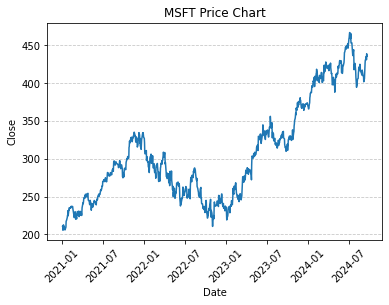

In [8]:
df_pricing_daily_ticker = df_pricing[df_pricing['Ticker'] == ticker].copy() 
plot_pricing_line(df_pricing_daily_ticker, ticker, 'Daily', 'Close')


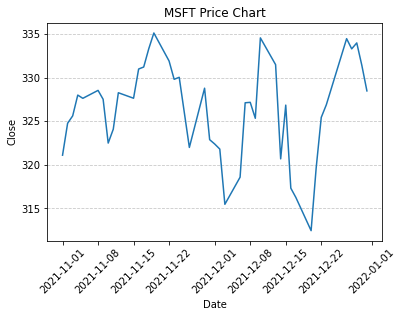

In [9]:
date_filter = (df_pricing_daily_ticker['Date'] >= '2021-11-01') & (df_pricing_daily_ticker['Date'] <= '2021-12-31')
df_pricing_daily_ticker = df_pricing_daily_ticker.loc[date_filter]
plot_pricing_line(df_pricing_daily_ticker, ticker, 'Daily', 'Close')


In [10]:
df_yearly_ret = calculate_return(df_pricing_yr.copy(), 'Year')
df_yearly_ret_ticker = df_yearly_ret[df_yearly_ret['Ticker'] == ticker].copy()
df_yearly_ret_ticker = df_yearly_ret_ticker[['Ticker', 'Year', 'Date', 'Year % Return']]
print(df_yearly_ret_ticker.to_string(index=False))


Ticker  Year       Date  Year % Return
  MSFT  2021 2021-12-31          47.61
  MSFT  2022 2022-12-30         -28.02
  MSFT  2023 2023-12-29          58.19
  MSFT  2024 2024-09-20          16.38


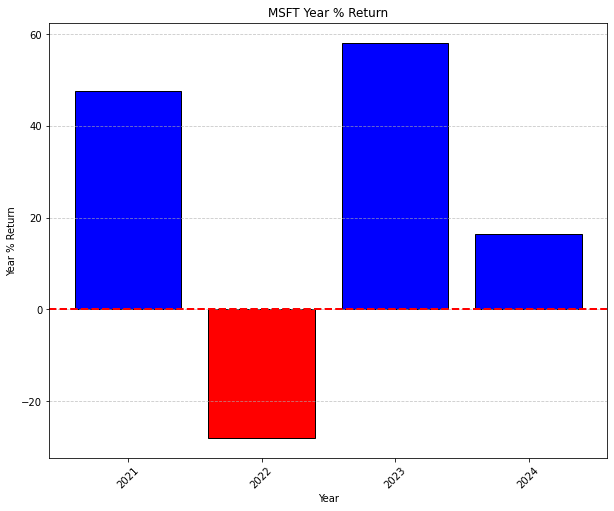

In [11]:
plot_returns_bar_chart(df_yearly_ret_ticker, ticker, 'Year', 'Year % Return')

In [12]:
df_pricing_qtr = get_pricing_data(df_pricing.copy(), 'Quarter')
df_quarterly_ret = calculate_return(df_pricing_qtr.copy(), 'Quarter')
df_comb_ret = pd.merge(df_yearly_ret, df_quarterly_ret, on=['Ticker', 'Year'])
df_comb_ret.rename(columns={'Date_y': 'Date'}, inplace=True)
df_comb_ret.sort_values(by=['Ticker', 'Year', 'Quarter'], inplace=True)
    
df_comb_ret_ticker = df_comb_ret[df_comb_ret['Ticker'] == ticker].copy()
df_comb_ret_ticker = df_comb_ret_ticker[['Ticker', 'Year', 'Year % Return', 'Quarter', 'Date', 'Quarter % Return']]

print(df_comb_ret_ticker.to_string(index=False))


Ticker  Year  Year % Return  Quarter       Date  Quarter % Return
  MSFT  2021          47.61        1 2021-03-31              2.85
  MSFT  2021          47.61        2 2021-06-30             15.17
  MSFT  2021          47.61        3 2021-09-30              4.27
  MSFT  2021          47.61        4 2021-12-31             19.51
  MSFT  2022         -28.02        1 2022-03-31             -8.14
  MSFT  2022         -28.02        2 2022-06-30            -16.50
  MSFT  2022         -28.02        3 2022-09-30             -9.13
  MSFT  2022         -28.02        4 2022-12-30              3.26
  MSFT  2023          58.19        1 2023-03-31             20.51
  MSFT  2023          58.19        2 2023-06-30             18.38
  MSFT  2023          58.19        3 2023-09-29             -7.08
  MSFT  2023          58.19        4 2023-12-29             19.34
  MSFT  2024          16.38        1 2024-03-28             12.09
  MSFT  2024          16.38        2 2024-06-28              6.43
  MSFT  20

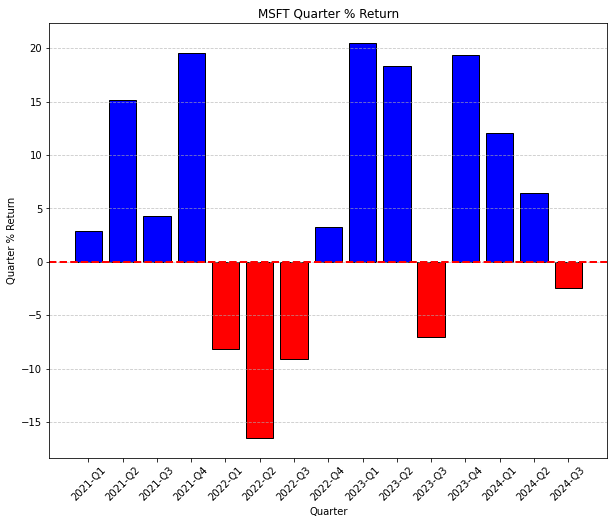

In [13]:
plot_returns_bar_chart(df_comb_ret_ticker, ticker, 'Quarter', 'Quarter % Return')


In [14]:
df_comb_stats_ticker = calculate_stats(df_comb_ret_ticker.copy(), 'Ticker', 'Quarter')
print(df_comb_stats_ticker.to_string(index=False))


Ticker  Year  Year % Return  Lowest Quarter % Return  Highest Quarter % Return  Average Quarter % Return  Median Quarter % Return  Quarter % Variance
  MSFT  2021          47.61                     2.85                     19.51                     10.45                     9.72                7.08
  MSFT  2022         -28.02                   -16.50                      3.26                     -7.63                    -8.64                7.07
  MSFT  2023          58.19                    -7.08                     20.51                     12.79                    18.86               11.50
  MSFT  2024          16.38                    -2.44                     12.09                      5.36                     6.43                5.98


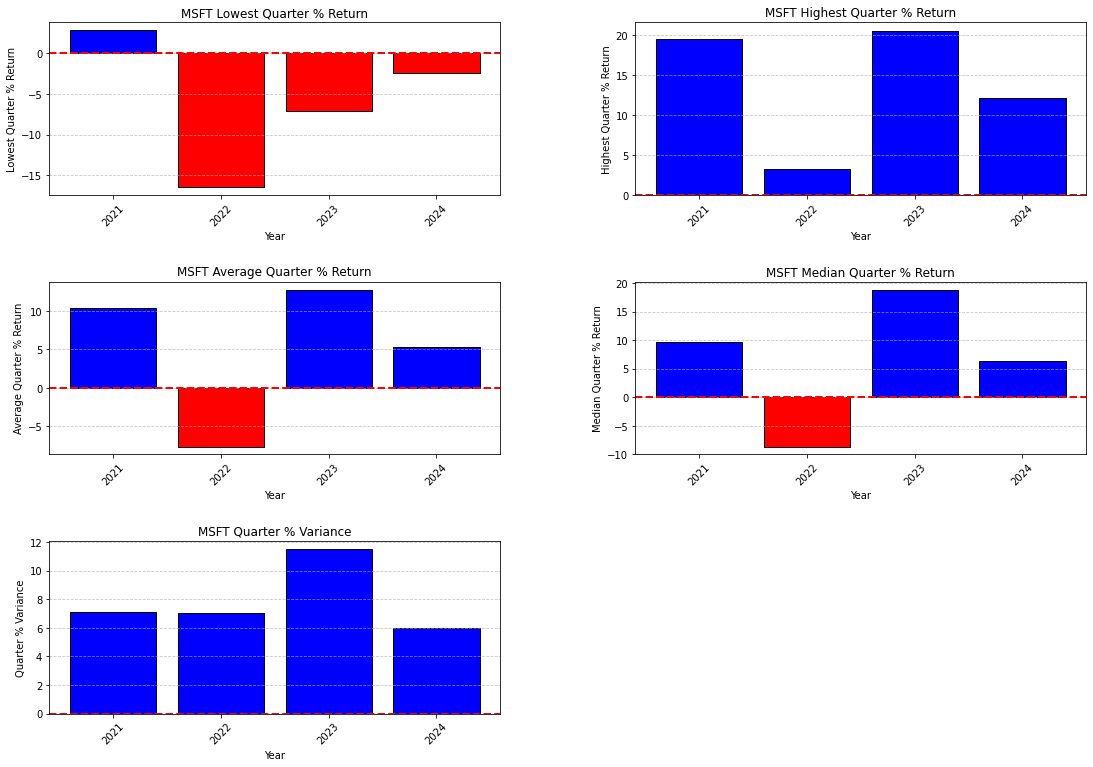

In [15]:
plot_period_stats_by_year_bar_charts(df_comb_stats_ticker, 'Ticker', 'MSFT')


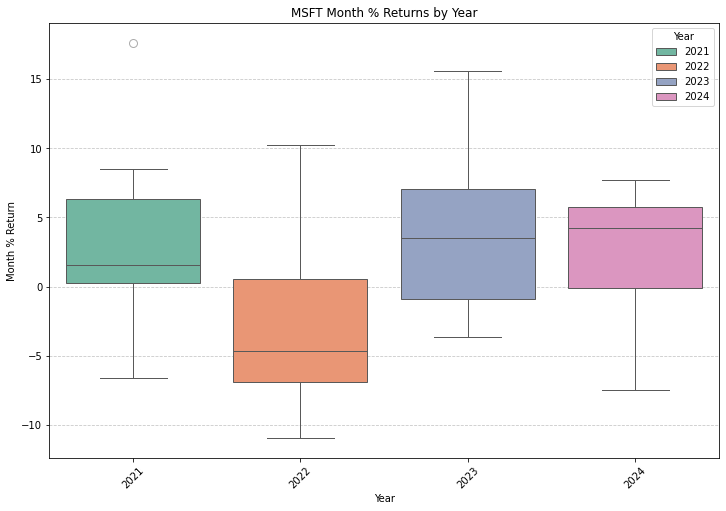

In [16]:
df_pricing_mth = get_pricing_data(df_pricing.copy(), 'Month')
df_monthly_ret = calculate_return(df_pricing_mth.copy(), 'Month')
df_monthly_ret_ticker = df_monthly_ret[df_monthly_ret['Ticker'] == ticker].copy()
df_monthly_ret_ticker = df_monthly_ret_ticker[['Ticker', 'Year', 'Month', 'Month % Return']]
plot_period_returns_by_year_box_plot(df_monthly_ret_ticker, ticker, 'Month')


In [17]:
df_yearly_ret['Year % Return Rank'] = df_yearly_ret.groupby('Year')['Year % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 5
df_yearly_ret_top = df_yearly_ret[df_yearly_ret['Year % Return Rank'] <= num_of_ranks].copy()
df_yearly_ret_top = df_yearly_ret_top [['Ticker', 'Year', 'Year % Return', 'Year % Return Rank']]
df_yearly_ret_top.sort_values(by=['Year', 'Year % Return Rank'], inplace=True)

print(df_yearly_ret_top.to_string(index=False))


Ticker  Year  Year % Return  Year % Return Rank
  FTNT  2021         140.24                   1
  MRNA  2021         136.86                   2
   DVN  2021         133.44                   3
   MRO  2021         132.30                   4
  NVDA  2021         123.95                   5
   CEG  2022         122.95                   1
   OXY  2022         119.05                   2
   HES  2022          94.01                   3
   XOM  2022          87.40                   4
  SMCI  2022          86.80                   5
  SMCI  2023         246.24                   1
  NVDA  2023         239.11                   2
  META  2023         194.13                   3
   RCL  2023         162.00                   4
  BLDR  2023         157.31                   5
   VST  2024         182.41                   1
  NVDA  2024         134.30                   2
   CEG  2024         119.30                   3
    GE  2024          84.64                   4
   HWM  2024          80.50             

In [18]:
plot_top_returns_bar_chart(df_yearly_ret_top, 'Ticker', 'Year')


In [19]:
# Determine the first date for each ticker
first_dates = df_pricing.groupby('Ticker')['Date'].min().reset_index()
first_dates.rename(columns={'Date': 'First Date'}, inplace=True)

# Count how many tickers share the same first date
count_first_dates = first_dates['First Date'].value_counts().reset_index()
count_first_dates.columns = ['First Date', 'Count']

# Filter for first dates that occur more than once and take the min date
valid_first_dates = count_first_dates[count_first_dates['Count'] > 1]['First Date']
min_valid_first_date = valid_first_dates.min()

# Merge back to keep only those tickers with the same first date
df_pricing_filtered = df_pricing.merge(first_dates, on='Ticker', suffixes=('', '_y'))  # Specify suffixes here
df_pricing_filtered = df_pricing_filtered[df_pricing_filtered['First Date'].isin([min_valid_first_date])].copy()

df_pricing_filtered.drop(columns=['First Date'], inplace=True)
    
if 'First Date_y' in df_pricing_filtered.columns:
    df_pricing_filtered.drop(columns=['First Date_y'], inplace=True)
    
df_pricing_filtered.sort_values(by=['Ticker', 'Date'], inplace=True)


# Show count of original Tickers
ticker_cnt = len(df_pricing['Ticker'].unique())
ticker_cnt2 = len(df_pricing_filtered['Ticker'].unique())
print(f'Original Ticker list count: {ticker_cnt}')
print(f'Filtered Ticker list count: {ticker_cnt2}')


Original Ticker list count: 503
Filtered Ticker list count: 496


In [20]:
last_dates = df_pricing_filtered['Date'].max()
three_years_ago = last_dates - pd.DateOffset(days=365 * 3)
three_years_ago_str = three_years_ago.strftime('%Y-%m-%d')

df_ret = calculate_return(df_pricing_filtered.copy(), 'Daily')
date_filter = (df_ret['Date'] >= three_years_ago_str)
df_ret_filter = df_ret.loc[date_filter]


In [21]:
df_ret_filter_last = df_ret_filter.copy().groupby('Ticker').tail(1)
df_ret_filter_last.loc[:, 'Cumulative % Return Rank'] = df_ret_filter_last.groupby('Date')['Cumulative % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Cumulative % Return Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Cumulative % Return', 'Cumulative % Return Rank']]
df_ret_filter_last_top.sort_values(by=['Cumulative % Return Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Cumulative % Return  Cumulative % Return Rank
  SMCI 2024-09-20              1337.96                         1
  NVDA 2024-09-20               784.82                         2
  TRGP 2024-09-20               470.47                         3
   VST 2024-09-20               449.29                         4
   LLY 2024-09-20               445.20                         5
  ANET 2024-09-20               428.90                         6
  BLDR 2024-09-20               379.37                         7
   MRO 2024-09-20               311.95                         8
   PWR 2024-09-20               310.22                         9
   MPC 2024-09-20               293.94                        10


In [22]:
top_tickers = df_ret_filter_last_top['Ticker'].unique()
df_ret_filter_top = df_ret_filter[df_ret_filter['Ticker'].isin(top_tickers)].copy()
plot_returns_line_chart(df_ret_filter_top, 'Daily', 'Cumulative % Return', 'Ticker')


In [23]:
df_ret_filter_last.loc[:, 'Annualized % Return Rank'] = df_ret_filter_last.groupby('Date')['Annualized % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Annualized % Return Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Annualized % Return', 'Annualized % Return Rank']]
df_ret_filter_last_top.sort_values(by=['Annualized % Return Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Annualized % Return  Annualized % Return Rank
  SMCI 2024-09-20               105.13                         1
  NVDA 2024-09-20                79.97                         2
  TRGP 2024-09-20                59.89                         3
   VST 2024-09-20                58.27                         4
   LLY 2024-09-20                57.95                         5
  ANET 2024-09-20                56.66                         6
  BLDR 2024-09-20                52.56                         7
   MRO 2024-09-20                46.46                         8
   PWR 2024-09-20                46.29                         9
   MPC 2024-09-20                44.70                        10


In [24]:
df_ret_filter2 = calculate_drawdowns(df_ret_filter.copy(), 'Ticker', 'Daily')

df_ret_filter_top = df_ret_filter2[df_ret_filter2['Ticker'].isin(top_tickers)].copy()
df_ret_filter_last_top = df_ret_filter_top.copy().groupby('Ticker').tail(1)
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Cumulative % Return', 'Annualized % Return', '% Drawdown', 'Max % Drawdown', 'Max Drawdown Date']]
df_ret_filter_last_top.sort_values(by=['Cumulative % Return'], ascending=False, inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Cumulative % Return  Annualized % Return  % Drawdown  Max % Drawdown Max Drawdown Date
  SMCI 2024-09-20              1337.96               105.13       63.20           80.24        2022-04-12
  NVDA 2024-09-20               784.82                79.97       15.98          109.35        2022-10-14
  TRGP 2024-09-20               470.47                59.89        0.00           46.19        2022-07-06
   VST 2024-09-20               449.29                58.27        0.00          916.00        2021-12-13
   LLY 2024-09-20               445.20                57.95        4.87           41.24        2022-02-14
  ANET 2024-09-20               428.90                56.66        0.00           76.09        2022-06-16
  BLDR 2024-09-20               379.37                52.56        7.88           80.27        2022-06-22
   MRO 2024-09-20               311.95                46.46       16.14           46.77        2022-07-14
   PWR 2024-09-20               310.22        

In [25]:
df_ret_filter_last = df_ret_filter2.copy().groupby('Ticker').tail(1)

df_ret_filter_last.loc[:, 'Annualized Volatility Rank'] = df_ret_filter_last.groupby('Date')['Annualized Volatility'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Annualized Volatility Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Annualized Volatility', 'Annualized Volatility Rank']]
df_ret_filter_last_top.sort_values(by=['Annualized Volatility Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Annualized Volatility  Annualized Volatility Rank
  SMCI 2024-09-20                  72.64                           1
  MRNA 2024-09-20                  66.82                           2
  ENPH 2024-09-20                  66.05                           3
  NCLH 2024-09-20                  59.36                           4
  TSLA 2024-09-20                  58.69                           5
  ETSY 2024-09-20                  58.64                           6
  PARA 2024-09-20                  58.31                           7
   CCL 2024-09-20                  57.84                           8
  EPAM 2024-09-20                  56.21                           9
   WBD 2024-09-20                  55.36                          10


In [26]:
risk_free_rate = 2.5
df_ret_filter2['Annualized Sharpe Ratio'] = np.where(
    df_ret_filter2['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_filter2['Annualized % Return'] - risk_free_rate) / df_ret_filter2['Annualized Volatility'], 2)
)
df_ret_filter2['Annualized Sortino Ratio'] = np.where(
    df_ret_filter2['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_filter2['Annualized % Return'] - risk_free_rate) / df_ret_filter2['Annualized Downside Volatility'], 2)
)
df_ret_filter_last = df_ret_filter2.copy().groupby('Ticker').tail(1)
df_ret_filter_last.loc[:, 'Annualized Sharpe Ratio Rank'] = df_ret_filter_last.groupby('Date')['Annualized Sharpe Ratio'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Annualized Sharpe Ratio Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Annualized Sharpe Ratio', 'Annualized Sharpe Ratio Rank']]
df_ret_filter_last_top.sort_values(by=['Annualized Sharpe Ratio Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Annualized Sharpe Ratio  Annualized Sharpe Ratio Rank
   LLY 2024-09-20                     1.87                             1
  TRGP 2024-09-20                     1.73                             2
  NVDA 2024-09-20                     1.44                             3
  SMCI 2024-09-20                     1.41                             4
   MCK 2024-09-20                     1.38                             5
  ACGL 2024-09-20                     1.37                             6
   VST 2024-09-20                     1.37                             6
   IRM 2024-09-20                     1.35                             7
  ANET 2024-09-20                     1.31                             8
   PWR 2024-09-20                     1.31                             8
   MPC 2024-09-20                     1.29                             9
    GE 2024-09-20                     1.20                            10


In [27]:
df_ret_filter_last.loc[:, 'Annualized Sortino Ratio Rank'] = df_ret_filter_last.groupby('Date')['Annualized Sortino Ratio'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Annualized Sortino Ratio Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Annualized Sortino Ratio', 'Annualized Sortino Ratio Rank']]
df_ret_filter_last_top.sort_values(by=['Annualized Sortino Ratio Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Annualized Sortino Ratio  Annualized Sortino Ratio Rank
   LLY 2024-09-20                      3.10                              1
  TRGP 2024-09-20                      2.52                              2
  NVDA 2024-09-20                      2.47                              3
  SMCI 2024-09-20                      2.20                              4
  ANET 2024-09-20                      2.08                              5
   PWR 2024-09-20                      2.06                              6
  ACGL 2024-09-20                      2.04                              7
   MPC 2024-09-20                      1.83                              8
   HWM 2024-09-20                      1.82                              9
    IT 2024-09-20                      1.81                             10


In [28]:
df_ret_filter2['Calmar Ratio'] = np.where(
    df_ret_filter2['Max % Drawdown'] == 0, 
    0, 
    round(df_ret_filter2['Annualized % Return'] / df_ret_filter2['Max % Drawdown'], 2)
)

df_ret_filter_last = df_ret_filter2.copy().groupby('Ticker').tail(1)
df_ret_filter_last.loc[:, 'Calmar Ratio Rank'] = df_ret_filter_last.groupby('Date')['Calmar Ratio'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 10
df_ret_filter_last_top = df_ret_filter_last[df_ret_filter_last['Calmar Ratio Rank'] <= num_of_ranks].copy()
df_ret_filter_last_top = df_ret_filter_last_top[['Ticker', 'Date', 'Calmar Ratio', 'Calmar Ratio Rank']]
df_ret_filter_last_top.sort_values(by=['Calmar Ratio Rank'], inplace=True)

print(df_ret_filter_last_top.to_string(index=False))


Ticker       Date  Calmar Ratio  Calmar Ratio Rank
   LLY 2024-09-20          1.41                  1
  SMCI 2024-09-20          1.31                  2
  TRGP 2024-09-20          1.30                  3
   MCK 2024-09-20          1.21                  4
   MRO 2024-09-20          0.99                  5
   PWR 2024-09-20          0.94                  6
   MPC 2024-09-20          0.91                  7
   XOM 2024-09-20          0.89                  8
  FANG 2024-09-20          0.82                  9
   IRM 2024-09-20          0.80                 10


In [29]:
s1.close()
